In [ ]:
#Installation of the necessary library

!pip install cvlib==0.2.2
!pip install opencv-python==4.1.1.26
!pip install tensorflow==1.14.0
!pip install matplotlib==3.1.1
!pip install Keras==2.2.5
!pip install pmdarima==1.8.4

## Image Data Extraction - 
### This section will extract the number of vehicles within each image taken

In [2]:
#Setting up the environment for the analytics to be performed
from platform import python_version
import tensorflow
import keras
import cvlib as cv
from cvlib.object_detection import draw_bbox
import cv2
import json
import matplotlib.pyplot as plt
from PIL import Image
import requests
import numpy as np
import urllib.parse
import pandas as pd
from requests.models import Response
from datetime import datetime, timedelta, timezone

print('Python version: {}'.format(python_version()))
print('cvlib version: {}'.format(cv.__version__))
print('OpenCV version: {}'.format(cv2.__version__))
print('Tensorflow version: {}'.format(tensorflow.__version__))
print('Keras version: {}'.format(keras.__version__))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Python version: 3.7.12
cvlib version: 0.2.2
OpenCV version: 4.1.1
Tensorflow version: 1.14.0
Keras version: 2.2.5


In [3]:
#Image processing function

def traffic_counter(image):
  bbox, label, conf = cv.detect_common_objects(image, confidence=0.3, nms_thresh=0.3)
  #the reason for the confidence to be at 0.3 is to increase the coverage due to poor weather condition that the algorithm will recoginse the vehicles
  output_image = draw_bbox(image, bbox, label, conf)
  # plt.imshow(output_image)
  # plt.show()
  print('Number of cars in the image is ' + str(label.count('car')))
  print('Number of bus in the image is ' + str(label.count('bus')))
  print('Number of truck in the image is ' + str(label.count('truck')))
  print('Number of motorcycle in the image is ' + str(label.count('motorcycle')))
  car = label.count('car')
  bus = label.count('bus')
  truck = label.count('truck')
  motorcycle = label.count('motorcycle')
  return (car, bus, truck, motorcycle)

In [4]:
#conversion of url images into opencv image

#The reason for using PIL in the case is that cv2 is not able to directly read 
#from the image_url generating from the API calls

def url_to_image(url):
  im = Image.open(requests.get(url, stream=True).raw).convert('RGB')
  # Convert RGB to BGR 
  opencvImage = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
  # cv2.imwrite('testing.jpg', opencvImage)
  # plt.imshow(im)
  # plt.show()
  return opencvImage

In [5]:
#this function is to enable us to generate the amount of data we need to collect for the analysis

def data_generation(current, days, interval, latitude, longitude):
  current_date = current.astimezone(timezone(timedelta(hours=8), name = 'SGT')).replace(microsecond=0)
  past_date_week = current_date - timedelta(days = days)
  delta = timedelta(minutes=interval) 
  data = []
  df_historical = pd.DataFrame(data, columns=['Date', 'Car', 'Bus', 'Truck','Motorcycle', 'Total']) 
  while past_date_week <= current_date:
      print("scanning on date:", past_date_week)
      variable = past_date_week.isoformat()
      print(urllib.parse.quote(variable))
      new_variable = urllib.parse.quote(variable)
      URL = f"https://api.data.gov.sg/v1/transport/traffic-images?date_time={new_variable}"
      print(URL)
      x = requests.get(URL)
      todos = json.loads(x.text)
      data = todos['items'][0]['cameras']
      timestamp = datetime.strptime(todos['items'][0]['timestamp'], "%Y-%m-%dT%H:%M:%S%z").strftime('%d-%m-%y %H:%M:%S')
      for i in data:
        if i['location']['latitude'] == latitude and i['location']['longitude'] == longitude:
          # Filename
          url_image = i['image']
          print(url_image)
          image = url_to_image(url_image)
          car, bus, truck, motorcycle = traffic_counter(image)
          total = car + bus + truck
          print('Image process completed')
          new_row ={'Date': timestamp, 'Car': car, 'Bus': bus, "Truck": truck,"Motorcycle": motorcycle, 'Total': total}
          df_historical = df_historical.append(new_row, ignore_index=True)
          past_date_week += delta
      print("Current Date, dataset processed")
  return df_historical 
          

In [ ]:
# Data Generation for analytics

#Changable Variables
current_date = datetime.now()
forecast_period = 3
days = 7
interval = 30 
latitude = 1.357098686
longitude = 103.902042

df = data_generation(current_date, days, interval, latitude, longitude)
#print(df)

Till this portion, we will be able to generate the datatable (Univerable Dataset) for future analytics. Subsequently we will be building a univerate forecasting.

EDA 

In [7]:
# Setting up the Analytics Library
import  statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
from pmdarima import auto_arima                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [8]:
df_2 = df[['Date', 'Total']]
df_2.Date = pd.to_datetime(df_2.Date)
df_2 = df_2.set_index("Date")
df_2.index.freq
df_2.head()

,Total
Date,
2021-12-14 17:23:01,13
2021-12-14 17:53:02,11
2021-12-14 18:23:03,12
2021-12-14 18:53:04,11
2021-12-14 19:23:05,2


In [9]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('No of Vehicles')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

In [10]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_2)

(0.01, False)

From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

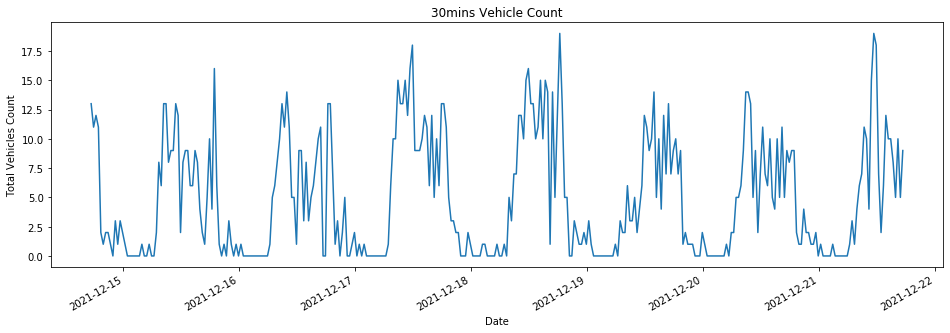

In [11]:
ax = df_2['Total'].plot(figsize = (16,5), title = "30mins Vehicle Count")
ax.set(xlabel='Date', ylabel='Total Vehicles Count');

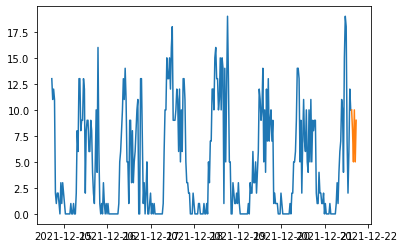

In [12]:
train_data = df_2[:len(df)-6]
test_data = df_2[len(df)-6:]
plt.plot(train_data)
plt.plot(test_data)

In [13]:
arima_model =  auto_arima(train_data,start_p=0, d=1, start_q=0, 
                          max_p=10, max_d=10, max_q=10, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1950.664, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1828.501, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1896.896, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1794.982, Time=0.63 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1739.590, Time=1.36 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1738.820, Time=2.21 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1740.657, Time=3.48 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=1740.073, Time=7.02 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=1722.857, Time=5.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=1721.342, Time=6.16 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.06 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=17.13 sec
 ARIMA(1,1,0)(3,1,3)[12]             :

In [14]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  331
Model:             SARIMAX(4, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood                -842.865
Date:                                 Tue, 21 Dec 2021   AIC                           1705.731
Time:                                         09:47:19   BIC                           1743.351
Sample:                                              0   HQIC                          1720.756
                                                 - 331                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4115      0.048     -8.516      0.000      -0.506      -0.317
ar.L2         -0.2433      0.047     -5.188      0.000      -0.335      -0.151
ar.L3         -0.2004      0.052     -3.845      0.000      -0.302      -0.098
ar.L4         -0.1959      0.061     -3.217      0.001      -0.315      -0.077
ar.S.L12      -0.6275      0.311     -2.015      0.044      -1.238      -0.017
ar.S.L24      -0.3352      0.087     -3.857      0.000      -0.506      -0.165
ar.S.L36      -0.2720      0.077     -3.548      0.000      -0.422      -0.122
ma.S.L12      -0.3847      0.314     -1.225      0.221      -1.000       0.231
ma.S.L24      -0.3786      0.294     -1.287      0.198      -0.955       0.198
sigma2        10.8283      0.731     14.809      0.000       9.395      12.261
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                32.67
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.05
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
prediction = arima_model.predict(n_periods = 6)
test_data['ARIMA_Predictions'] = prediction
test_data
# test_data['Total'].plot(figsize = (16,5), legend=True)
# test_data['AutoARIMA_Predictions'].plot(legend = True);

,Total,ARIMA_Predictions
Date,,
2021-12-21 14:53:12,10,9.093200
2021-12-21 15:23:13,8,8.857868
2021-12-21 15:53:14,5,8.566975
2021-12-21 16:23:15,10,8.485624
2021-12-21 16:53:16,5,8.772611
2021-12-21 17:23:17,9,8.355298


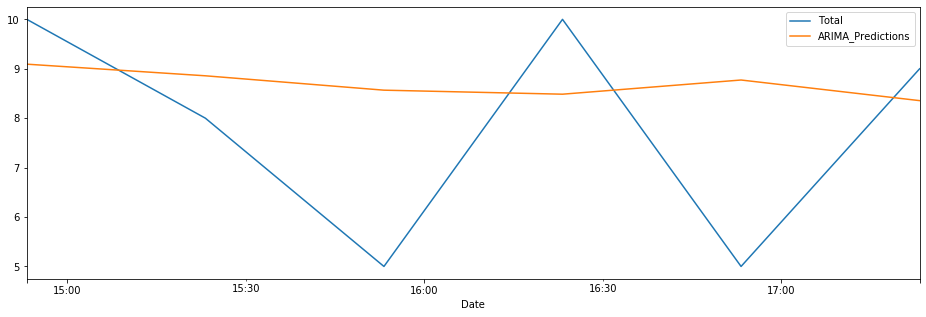

In [16]:
test_data['Total'].plot(figsize = (16,5), legend=True)
test_data['ARIMA_Predictions'].plot(legend = True);

In [17]:
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

arima_rmse_error = rmse(test_data['Total'], prediction)
arima_mse_error = arima_rmse_error**2
arima_r2_score = r2_score(test_data['Total'], prediction)
arima_MAPE = mape(test_data['Total'], prediction)
mean_value = df['Total'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value} \nR2_Score:{arima_r2_score} \nMAPE:{arima_MAPE}')

MSE Error: 5.20385085326395
RMSE Error: 2.281195049368631
Mean: 4.884272997032641 
R2_Score:-0.16359397961181488 
MAPE:31.48169831001987


In the case although MAPE seems high but it is due to low volume data.

LSTM Forecast

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 20
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 200)           161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 211,851
Trainable params: 211,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
311/311 [==============================] - 12s 38ms/step - loss: 0.0519
Epoch 2/20
311/311 [==============================] - 11s 34ms/step - loss: 0.0370
Epoch 3/20
311/311 [==============================] - 11s 37ms/step - loss: 0.0329
Epoch 4/20
311/311 [==============================] - 11s 34ms/step - loss: 0.0291
Epoch 5/20
311/311 [==============================] - 11s 35ms/step - loss: 0.0315
Epoch 6/20
311/311 [==============================] - 14s 46ms/step - loss: 0.0298
Epoch 7/20
311/311 [==============================] - 12s 39ms/step - loss: 0.0297
Epoch 8/20
311/311 [==============================] - 11s 35ms/step - loss: 0.0287
Epoch 9/20
311/311 [==============================] - 11s 35ms/step - loss: 0.0277
Epoch 10/20
311/311 [==============================] - 11s 36ms/step - loss: 0.0285
Epoch 11/20
311/311 [==============================] - 13s 41ms/step - lo

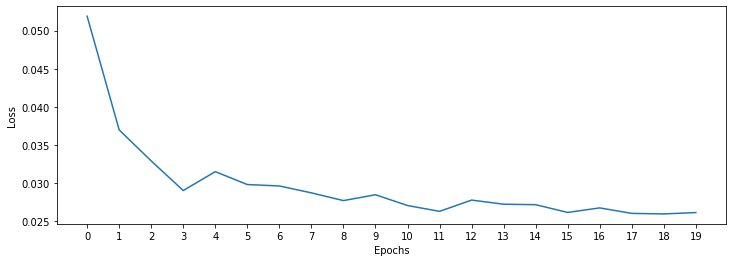

In [21]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [22]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Total,ARIMA_Predictions,LSTM_Predictions
Date,,,
2021-12-21 14:53:12,10,9.093200,7.372965
2021-12-21 15:23:13,8,8.857868,6.413776
2021-12-21 15:53:14,5,8.566975,5.820213
2021-12-21 16:23:15,10,8.485624,5.276061
2021-12-21 16:53:16,5,8.772611,4.692193
2021-12-21 17:23:17,9,8.355298,4.302424


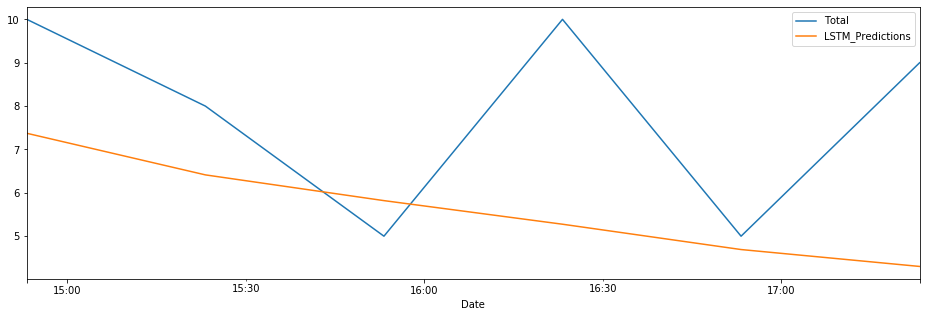

In [23]:
test_data['Total'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [24]:
lstm_rmse_error = rmse(test_data['Total'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Total'].mean()
lstm_r2_score = r2_score(test_data['Total'], test_data['LSTM_Predictions'])
lstm_MAPE = mape(test_data['Total'], test_data['LSTM_Predictions'])

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value} \nR2_Score:{lstm_r2_score} \nMAPE:{lstm_MAPE}')

MSE Error: 9.094623358096028
RMSE Error: 3.015729324408281
Mean: 4.884272997032641 
R2_Score:-1.0335803782078075 
MAPE:28.015537733832996


Prophet Forecast

In [25]:
df_pr = df_2.copy()
df_pr = df_2.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df_2)-6]
test_data_pr = df_pr.iloc[len(df_2)-6:]

In [26]:
from fbprophet import Prophet

model = Prophet(changepoint_prior_scale=0.01).fit(train_data_pr)
future = model.make_future_dataframe(periods=6, freq='30min')
future.tail()
prophet_pred = model.predict(future)
prophet_pred.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-14 17:23:01,4.851696,4.852938,12.313194,4.851696,4.851696,3.946979,3.946979,3.946979,3.946979,3.946979,3.946979,0.0,0.0,0.0,8.798675
1,2021-12-14 17:53:02,4.851659,4.773117,12.537438,4.851659,4.851659,3.674626,3.674626,3.674626,3.674626,3.674626,3.674626,0.0,0.0,0.0,8.526286
2,2021-12-14 18:23:03,4.851623,4.350132,11.606696,4.851623,4.851623,3.076723,3.076723,3.076723,3.076723,3.076723,3.076723,0.0,0.0,0.0,7.928346
3,2021-12-14 18:53:04,4.851586,3.291205,11.102835,4.851586,4.851586,2.171050,2.171050,2.171050,2.171050,2.171050,2.171050,0.0,0.0,0.0,7.022636
4,2021-12-14 19:23:05,4.851550,2.028874,9.522466,4.851550,4.851550,1.027998,1.027998,1.027998,1.027998,1.027998,1.027998,0.0,0.0,0.0,5.879548


In [27]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred

,Pred
Date,
2021-12-21 14:53:12,7.750837
2021-12-21 15:23:12,7.931425
2021-12-21 15:53:12,8.232604
2021-12-21 16:23:12,8.552888
2021-12-21 16:53:12,8.775568
2021-12-21 17:23:12,8.790655


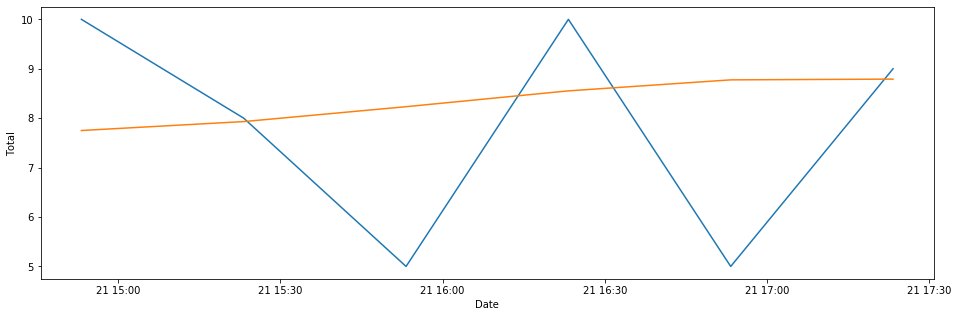

In [28]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Total"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [29]:
prophet_rmse_error = rmse(test_data['Total'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Total'].mean()
prophet_r2_score = r2_score(test_data['Total'], test_data["Prophet_Predictions"])
prophet_MAPE = mape(test_data['Total'], test_data["Prophet_Predictions"])
mean_value = df['Total'].mean()


print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value} \nR2_Score:{prophet_r2_score} \nMAPE:{prophet_MAPE}')

MSE Error: 5.317671985321825
RMSE Error: 2.3060078025283923
Mean: 4.884272997032641 
R2_Score:-0.18904466752537696 
MAPE:30.05156925047906


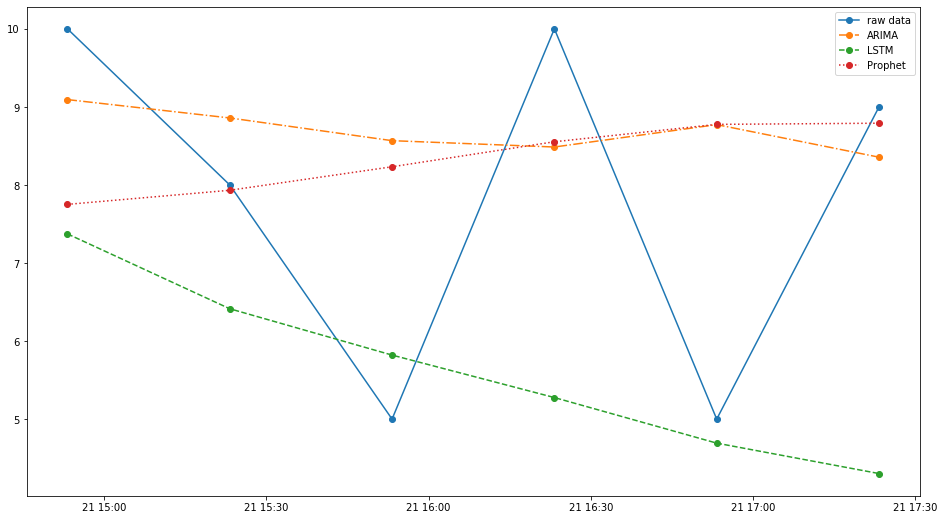

In [30]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
r2_result = [arima_r2_score, lstm_r2_score, prophet_r2_score]
mape_result = [arima_MAPE, lstm_MAPE, prophet_MAPE]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors, "R2 Score" : r2_result, "MAPE": mape_result})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Total"], linestyle="-",label='raw data')
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.", label='ARIMA')
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--",label='LSTM')
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":",label='Prophet')
plt.legend()
plt.show()

In [31]:
print(f"Mean: {test_data['Total'].mean()}")
errors

Mean: 7.833333333333333


,Models,RMSE Errors,MSE Errors,R2 Score,MAPE
0,ARIMA,2.281195,5.203851,-0.163594,31.481698
1,LSTM,3.015729,9.094623,-1.033580,28.015538
2,Prophet,2.306008,5.317672,-0.189045,30.051569


Hence, based on the analytics, Auto ARIMA model is selected.

Looking into Multivariate Time Series Forecasting where the weather data is being included

In [38]:
#this function is to enable us to generate the amount of data we need to collect for the analysis

def data_generation_weather(current, days, interval, latitude, longitude,station):
  current_date = current.astimezone(timezone(timedelta(hours=8), name = 'SGT')).replace(microsecond=0)
  past_date_week = current_date - timedelta(days = days)
  delta = timedelta(minutes=interval)
  weather_data= []
  temp = []
  data = []
  df_historical = pd.DataFrame(data, columns=['Date', 'Car', 'Bus', 'Truck','Motorcycle', 'Total', "Temp"]) 
  while past_date_week <= current_date:
      print("scanning on date:", past_date_week)
      variable = past_date_week.isoformat()
      print(urllib.parse.quote(variable))
      new_variable = urllib.parse.quote(variable)
      URL = f"https://api.data.gov.sg/v1/transport/traffic-images?date_time={new_variable}"
      URL_weather = f"https://api.data.gov.sg/v1/environment/air-temperature?date_time={new_variable}"
      print(URL)
      x = requests.get(URL)
      y = requests.get(URL_weather)
      todos = json.loads(x.text)
      todos_weather = json.loads(y.text)
      data = todos['items'][0]['cameras']
      weather_data = todos_weather['items'][0]['readings']
      timestamp = datetime.strptime(todos['items'][0]['timestamp'], "%Y-%m-%dT%H:%M:%S%z").strftime('%d-%m-%y %H:%M:%S')
      for i in weather_data:
        if i['station_id'] == station:
          temp.append(i['value'])
          print("Weather Temp:", i['value'])
      for i in data:
        if i['location']['latitude'] == latitude and i['location']['longitude'] == longitude:
          # Filename
          url_image = i['image']
          print(url_image)
          image = url_to_image(url_image)
          car, bus, truck, motorcycle = traffic_counter(image)
          total = car + bus + truck
          print('Image process completed')
          new_row ={'Date': timestamp, 'Car': car, 'Bus': bus, "Truck": truck,"Motorcycle": motorcycle, 'Total': total}
          df_historical = df_historical.append(new_row, ignore_index=True)
          past_date_week += delta
      print("Current Date, dataset processed")
      print("current Weather data", temp)
      df_historical['Temp'] = pd.Series(temp)
  return df_historical 

In [ ]:
# Data Generation for analytics

station = 'S43'

df_weather = data_generation_weather(current_date, days, interval, latitude, longitude, station)
print(df_weather)

In [45]:
#Creating new features from the weather components
df_weather['Temp'].fillna(int(df_weather ['Temp'].mean()), inplace=True)
df_3 = df_weather[['Date', 'Total', 'Temp']]
df_3.Date = pd.to_datetime(df_3.Date)
# day
df_3['Day'] = df_3['Date'].dt.day
# # month
# df_3['Month'] = df_3['Date'].dt.month
# # year
# df_3['Year'] = df_3['Date'].dt.year
# hour
df_3['Hour'] = df_3['Date'].dt.hour
# Monday is 0 and Sunday is 6
df_3['Weekday'] = df_3['Date'].dt.weekday
# week of the year
df_3['WeekNo'] = df_3['Date'].dt.week

df_3 = df_3.set_index("Date")


In [46]:
print(df_3.shape) #(49, 6)

(337, 6)


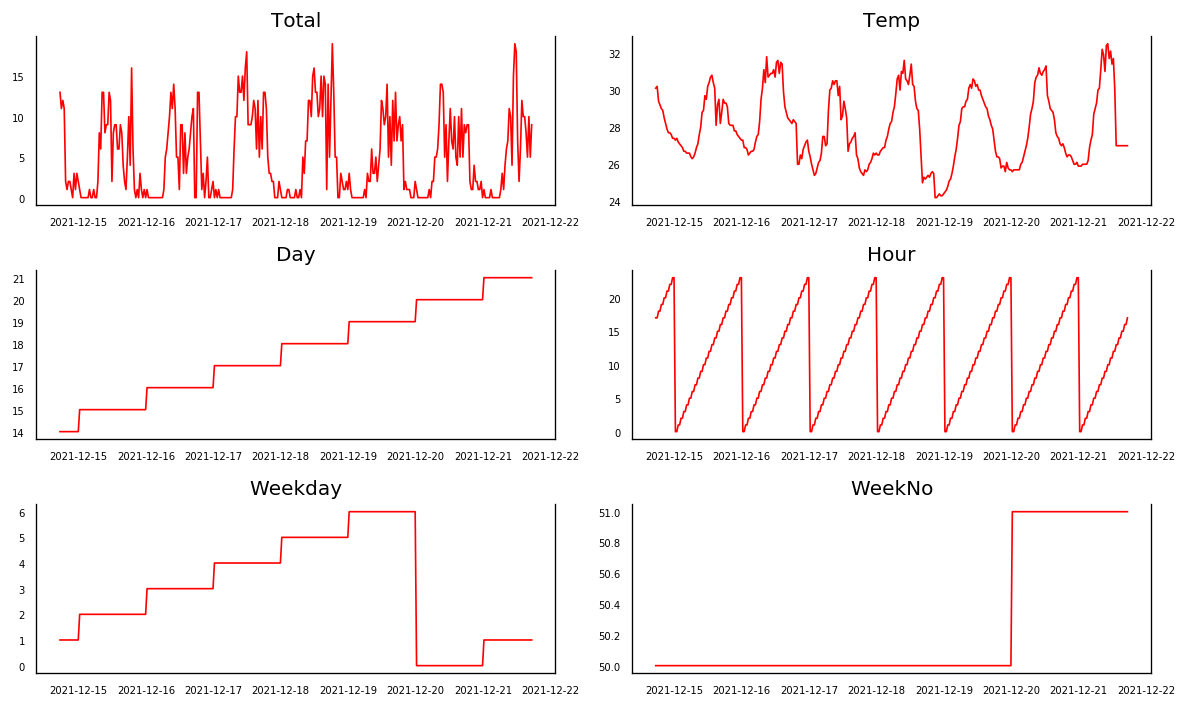

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_3[df_3.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_3.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


Stationary investigation

In [48]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [49]:
adf_test(df_3['Total'])
print('\n---------------------\n')
adf_test(df_3['Temp'])


Augmented Dickey-Fuller Test: 
ADF test statistic       -5.484194
p-value                   0.000002
# lags used              14.000000
# observations          322.000000
critical value (1%)      -3.450823
critical value (5%)      -2.870558
critical value (10%)     -2.571575
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

---------------------

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.724805e+00
p-value                 3.410975e-09
# lags used             1.100000e+01
# observations          3.250000e+02
critical value (1%)    -3.450632e+00
critical value (5%)    -2.870474e+00
critical value (10%)   -2.571530e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This means that the data stationary and it needs to be converted into stationary format

In [ ]:
df_difference = df_3.diff()

In [ ]:
adf_test(df_difference['Total'])
print('\n---------------------\n')
adf_test(df_difference['Temp'])

In [ ]:
df_difference_2 = df_difference.diff()

In [ ]:
adf_test(df_difference_2['Total'])
print('\n---------------------\n')
adf_test(df_difference_2['Temp'])

In [50]:
print('Total causes Temp?\n')
print('------------------')
granger_1 = grangercausalitytests(df_3[['Total', 'Temp']], 4)

print('\nTemp causes Total?\n')
print('------------------')
granger_2 = grangercausalitytests(df_3[['Temp', 'Total']], 4)

Total causes Temp?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.4345 , p=0.0000  , df_denom=333, df_num=1
ssr based chi2 test:   chi2=25.6636 , p=0.0000  , df=1
likelihood ratio test: chi2=24.7307 , p=0.0000  , df=1
parameter F test:         F=25.4345 , p=0.0000  , df_denom=333, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.6250 , p=0.0000  , df_denom=330, df_num=2
ssr based chi2 test:   chi2=25.6326 , p=0.0000  , df=2
likelihood ratio test: chi2=24.6993 , p=0.0000  , df=2
parameter F test:         F=12.6250 , p=0.0000  , df_denom=330, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2181  , p=0.0000  , df_denom=327, df_num=3
ssr based chi2 test:   chi2=25.1820 , p=0.0000  , df=3
likelihood ratio test: chi2=24.2779 , p=0.0000  , df=3
parameter F test:         F=8.2181  , p=0.0000  , df_denom=327, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

In [51]:
weather_data = df_3[['Total','Temp']]
print(weather_data.shape)

(337, 2)


In [65]:
#using 3 hours in the future as test set hence 6 parts
test_obs = 12
train_df = weather_data[:-test_obs]
test_df = weather_data[-test_obs:]

In [63]:
df_3

,Total,Temp,Day,Hour,Weekday,WeekNo
Date,,,,,,
2021-12-14 17:23:01,13,30.1,14,17,1,50
2021-12-14 17:53:02,11,30.2,14,17,1,50
2021-12-14 18:23:03,12,29.4,14,18,1,50
2021-12-14 18:53:04,11,29.2,14,18,1,50
2021-12-14 19:23:05,2,29.0,14,19,1,50
...,...,...,...,...,...,...
2021-12-21 15:23:13,8,27.0,21,15,1,51
2021-12-21 15:53:14,5,27.0,21,15,1,51
2021-12-21 16:23:15,10,27.0,21,16,1,51


In [66]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

In [67]:
model = VAR(train_df.astype(float).diff()[1:])

In [70]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.263       1.287       3.536       1.273
1        1.120      1.193*       3.064       1.149
2        1.096       1.218       2.991      1.145*
3        1.083       1.254       2.953       1.151
4       1.073*       1.293      2.924*       1.161
5        1.075       1.344       2.931       1.183
6        1.093       1.411       2.982       1.220
7        1.104       1.470       3.015       1.250
8        1.110       1.526       3.034       1.276
9        1.125       1.590       3.081       1.311
10       1.128       1.642       3.091       1.334
11       1.151       1.714       3.165       1.376
12       1.129       1.741       3.096       1.374
13       1.125       1.786       3.084       1.389
14       1.126       1.835       3.085       1.409
15       1.139       1.897       3.127       1.442
16       1.143       1.950     

In [81]:
train_df['Total'] = train_df['Total'].astype(float, errors = 'raise')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 2021-12-14 17:23:01 to 2021-12-21 11:23:06
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   0 non-null      float64
 1   Temp    325 non-null    float64
dtypes: float64(2)
memory usage: 7.6 KB


In [82]:
print(test_df.shape)

(12, 2)


In [88]:
result = model.fit(4)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Dec, 2021
Time:                     10:44:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.19537
Nobs:                     320.000    HQIC:                   1.06805
Log likelihood:          -1047.47    FPE:                    2.67362
AIC:                     0.983403    Det(Omega_mle):         2.52934
--------------------------------------------------------------------
Results for equation Total
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.034157         0.178745            0.191           0.848
L1.Total        -0.440225         0.055989           -7.863           0.000
L1.Temp          0.223526         0.363067            0.616           0.538
L2.T

In [89]:
lagged_Values = train_df.values[-4:]

In [ ]:
pred = result.forecast(y=lagged_Values, steps=12) 
print(pred)
# idx = pd.date_range(current_date periods=12)
# df_forecast=pd.DataFrame(data=pred, index=idx, columns=['money_2d', 'spending_2d'])

In [ ]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
print(var_model.endog_names)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

In [ ]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [ ]:
predictions.columns=['Total']
predictions

In [ ]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

In [ ]:
test_vs_pred.plot(figsize=(12,5))